In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import random

First let's look at the columns_description, seems interesting...

In [18]:
previous_app = pd.read_csv("C:/Users/pc/Downloads/previous_application.csv")
application_data = pd.read_csv("C:/Users/pc/Downloads/application_data.csv")


In [20]:
# Try different encodings for the third file
encodings = ['utf-8', 'windows-1252', 'iso-8859-1', 'latin1']

for encoding in encodings:
    try:
        columns_desc = pd.read_csv("C:/Users/pc/Downloads/columns_description.csv", encoding=encoding)
        print(f"Successfully read columns_description.csv with encoding: {encoding}")
        break
    except UnicodeDecodeError:
        print(f"Failed to read with encoding: {encoding}")

# Print shapes
print("Shape of previous_app:", previous_app.shape)
print("Shape of application_data:", application_data.shape)
print("Shape of columns_desc:", columns_desc.shape)

Failed to read with encoding: utf-8
Successfully read columns_description.csv with encoding: windows-1252
Shape of previous_app: (1670214, 37)
Shape of application_data: (307511, 122)
Shape of columns_desc: (160, 5)


Great, it's actually a CSV file. And now we've used `pandas` to import it as a `DataFrame` instance (hence the "df" in the name). How big is it I wonder?

In [22]:
print(previous_app.shape)

(1670214, 37)


Ok, about 300,000 rows, 122 columns. That's a lot of data. What does it look like?

In [8]:
previous_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


The most important column here is `TARGET`. The description for this variable is:

> Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Basically, this is the variable that the dataset is centered around. If this were a modeling competition, it would be the one we had to try to predict. Looking at the description it seems ot boil down to "did the perosn who made this application later miss a bunch of payments (a.k.a. credit card fraud, which also includes accidental fraud)?"

Let's see how many people committed fraud.

In [9]:
print("Columns in previous_app:")
print(previous_app.columns)

print("\nColumns in application_data:")
print(application_data.columns)

print("\nColumns in columns_desc:")
print(columns_desc.columns)

Columns in previous_app:
Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

Columns in application_data:
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTR

In [10]:
print("number of people who committed fraud:", application_data["TARGET"].sum())
print("proportion of people who committed fraud:", application_data["TARGET"].sum() / len(previous_app))

number of people who committed fraud: 24825
proportion of people who committed fraud: 0.014863364814329181


Now let's look at the other columns. Are there any columns that look like they might be predictive of fraud?

In [11]:
list(application_data.columns)


['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

`FLAG_OWNS_CAR` seems a likely candidate. I bet peole who own cars are less likely to miss payments. Let's see if this bears out in the data. First we'll create a new dataframe containing only those rows belonging to applicants who own cars.

In [12]:
car_owners = application_data[application_data["FLAG_OWN_CAR"] == "Y"]
print(car_owners.shape)

(104587, 122)


Looks like there are about 100,000 car owners in the data, around 1/3rd of the dataset. Now let's see if fraud is more or less common among car owners.

In [13]:
def show_fraud_prop(df):
    print("number of rows in dataframe:", len(df))
    print("number of positive targets:", df["TARGET"].sum())
    print("proportion of positive targets:", df["TARGET"].sum() / len(df))
    
show_fraud_prop(car_owners)

number of rows in dataframe: 104587
number of positive targets: 7576
proportion of positive targets: 0.07243730100299273


Hmm.. apparently car owners are slightly less likely to commit fraud, but only slightly. How about men vs women? First lets see what values are in this column:

In [14]:
application_data["CODE_GENDER"].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Apparently there are basically only two genders in this dataset, now which one commits more fraud? Probably the men right?

In [15]:
print("male fraud")
show_fraud_prop(application_data[application_data["CODE_GENDER"] == "M"])
print("female fraud")
show_fraud_prop(application_data[application_data["CODE_GENDER"] == "F"])

male fraud
number of rows in dataframe: 105059
number of positive targets: 10655
proportion of positive targets: 0.1014192025433328
female fraud
number of rows in dataframe: 202448
number of positive targets: 14170
proportion of positive targets: 0.06999328222555916


Knew it lol. Ok, how about income, let's use `pandas`'s `describe()` function to get a better idea about the distribution of the `AMT_INCOME_TOTAL` column:

In [16]:
application_data["AMT_INCOME_TOTAL"].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

Nice not having to calculate all those stats manually. Ok now let's compare fraud among high earners to fraud among low earners.

In [17]:
print("high earner fraud")
show_fraud_prop(application_data[application_data["AMT_INCOME_TOTAL"] > 2.025000e+05])

print("low earner fraud")
show_fraud_prop(application_data[application_data["AMT_INCOME_TOTAL"] < 1.125000e+05])

high earner fraud
number of rows in dataframe: 71538
number of positive targets: 4943
proportion of positive targets: 0.06909614470630994
low earner fraud
number of rows in dataframe: 69559
number of positive targets: 5723
proportion of positive targets: 0.0822754783708794


There isn't too much difference here... Ok, enough messing around, let's start plotting! We'll start simple. Let's create a bar chart over the gender data we were looking at earlier, using the python plotting library `seaborn` (imported as `sns`)

<Axes: xlabel='CODE_GENDER', ylabel='count'>

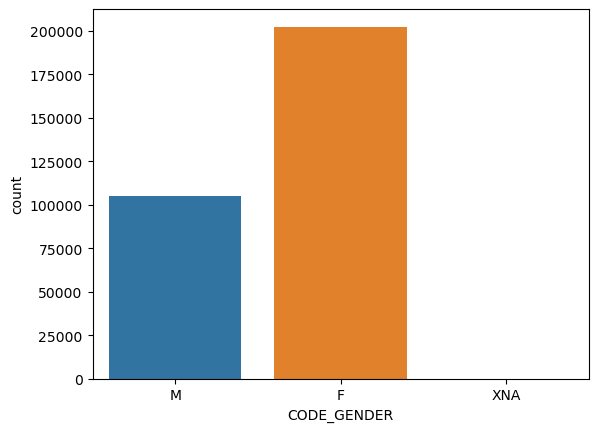

In [18]:
sns.countplot(x="CODE_GENDER", data=application_data)

That was easy eh? As we can see, it's plotted the number of rows in the dataset with male vs female applicants. Let's try another categorical column:

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

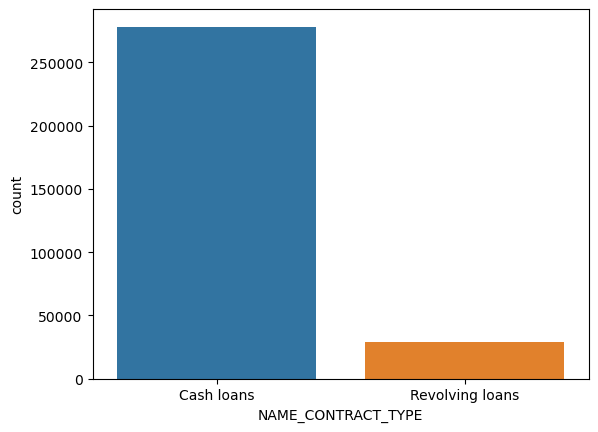

In [19]:
sns.countplot(x="NAME_CONTRACT_TYPE", data=application_data)

Apparently cash loans are much more popular. In general, looking a graphs is much easier on the eyes than squinting at printout, but the magic of plotting really gets started when you compare different variables on the same plot. 

Below is one of my favorite hand-spun custom plotting functions. I'm going to use it to plot the average fraud rate accross gender.

In [26]:
def mean_count_plot(df, col, target, rc={'figure.figsize':(15,10)}):
    sns.set(rc=rc)
    ax = sns.countplot(x=col, data=df)
    ax2 = ax.twinx()
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)    
    ax2 = sns.pointplot(x=col, y=target, data=df, color='black', legend=False, errwidth=0.5)
    ax.grid(False)

TypeError: pointplot() got an unexpected keyword argument 'legend'

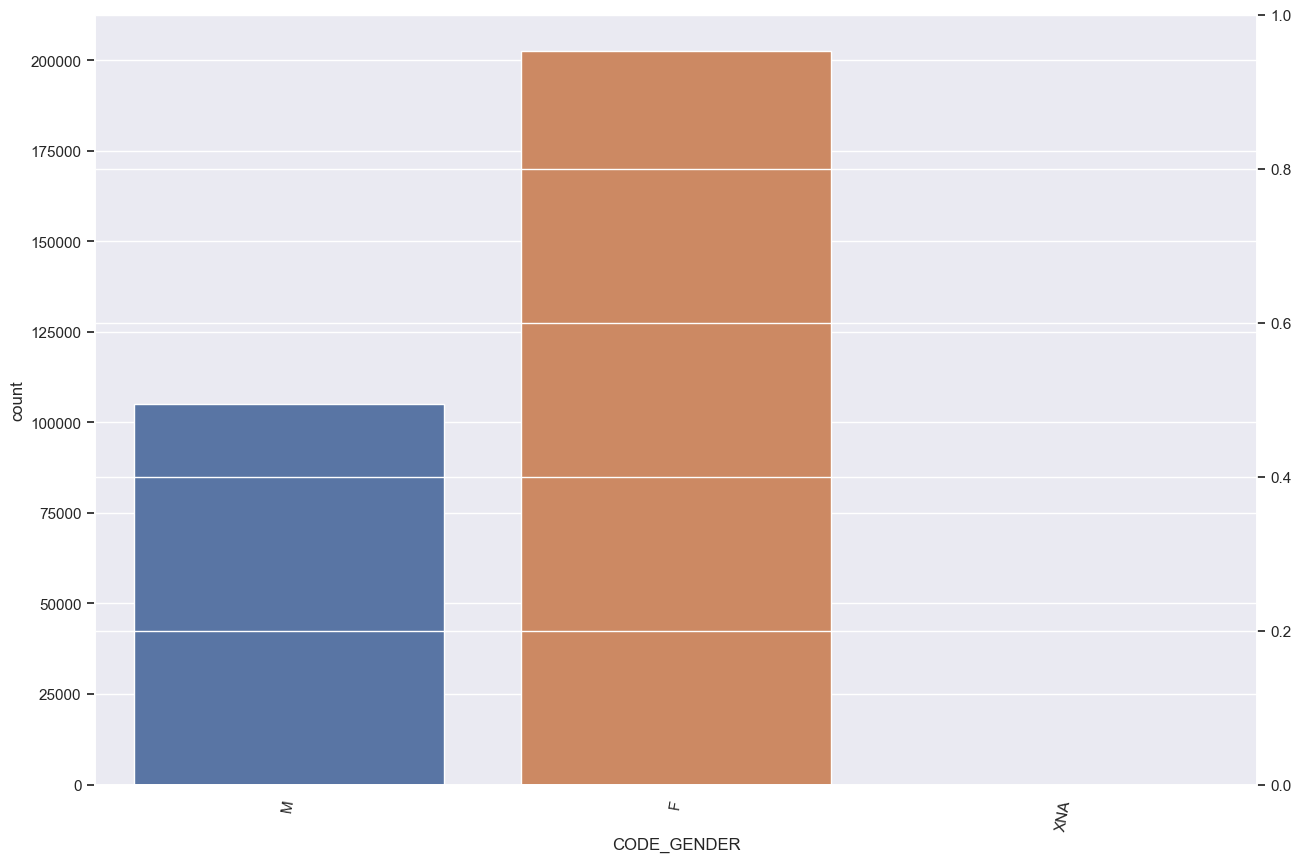

In [27]:
mean_count_plot(application_data, "CODE_GENDER", "TARGET")

Not bad eh? Much easier to parse than the `prints` we were doing earlier.

But we're just getting started baby. Now let's try some scatter plots over some of the numerical columns using `matplotlib` imported as `plt`. 

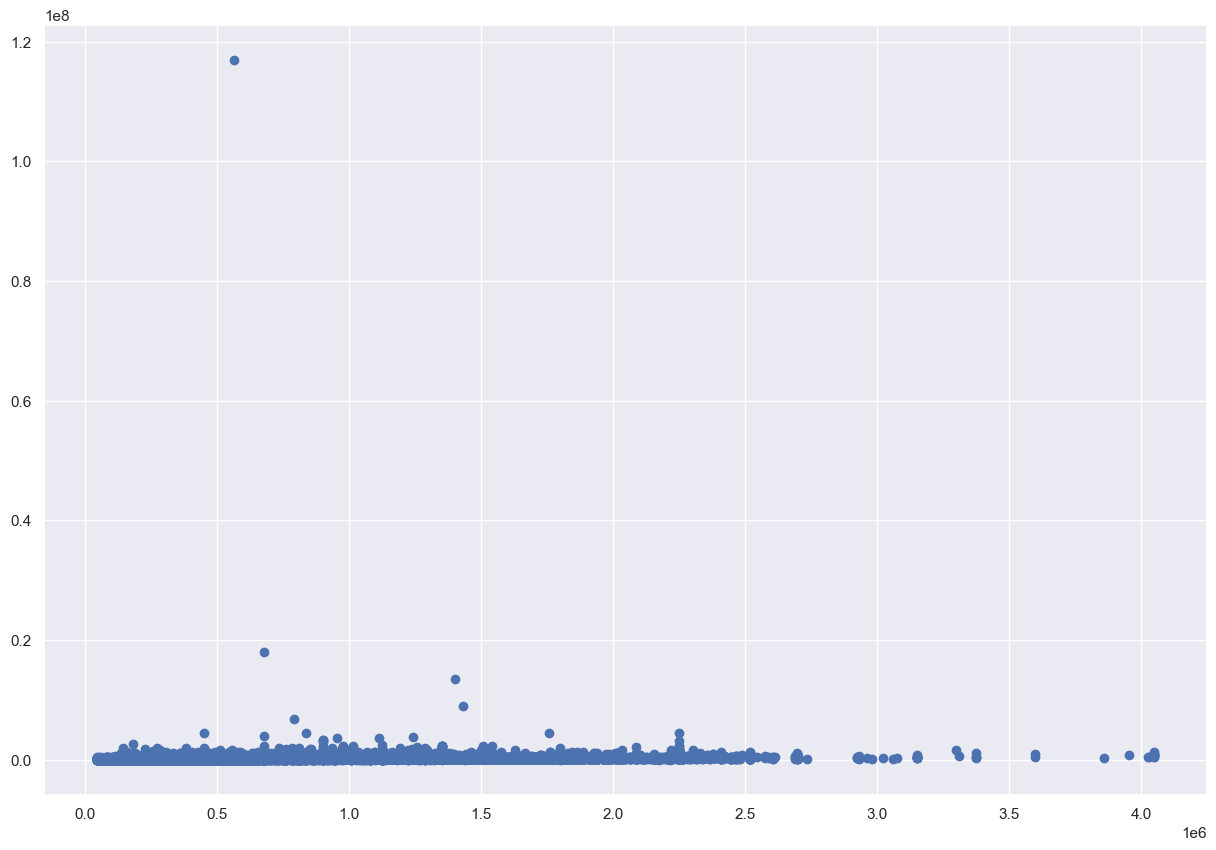

In [30]:
plt.scatter(application_data["AMT_CREDIT"], application_data["AMT_INCOME_TOTAL"])

Hmm... that wasn't super informative because the graph had to include that one person with a crazy high income. Let's remove that outlier and plot again. 

To help us do this we're going to use the `matplotlib` `Axis` class. Basically an `Axis` is a single graph. Usually I use the `Axis` object rather than `plt` when I need to make a more complicated graph.

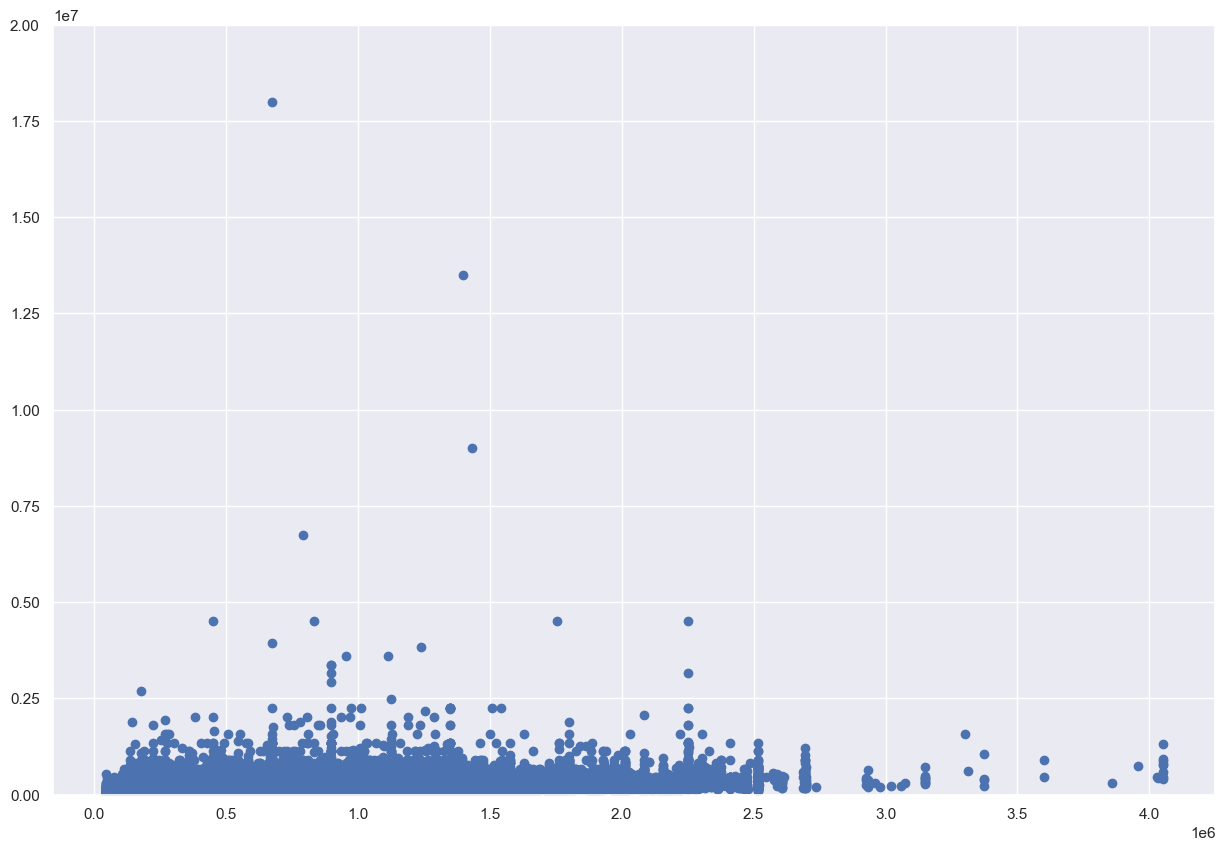

In [31]:
_, ax = plt.subplots()
ax.set_ylim((0, 2e7))
ax.scatter(application_data["AMT_CREDIT"], application_data["AMT_INCOME_TOTAL"])

Hmm... still not super informative because all the blue dots are overlapping. To get a bit more insight we'll lower the ceiling again and make the dots a little transparent.

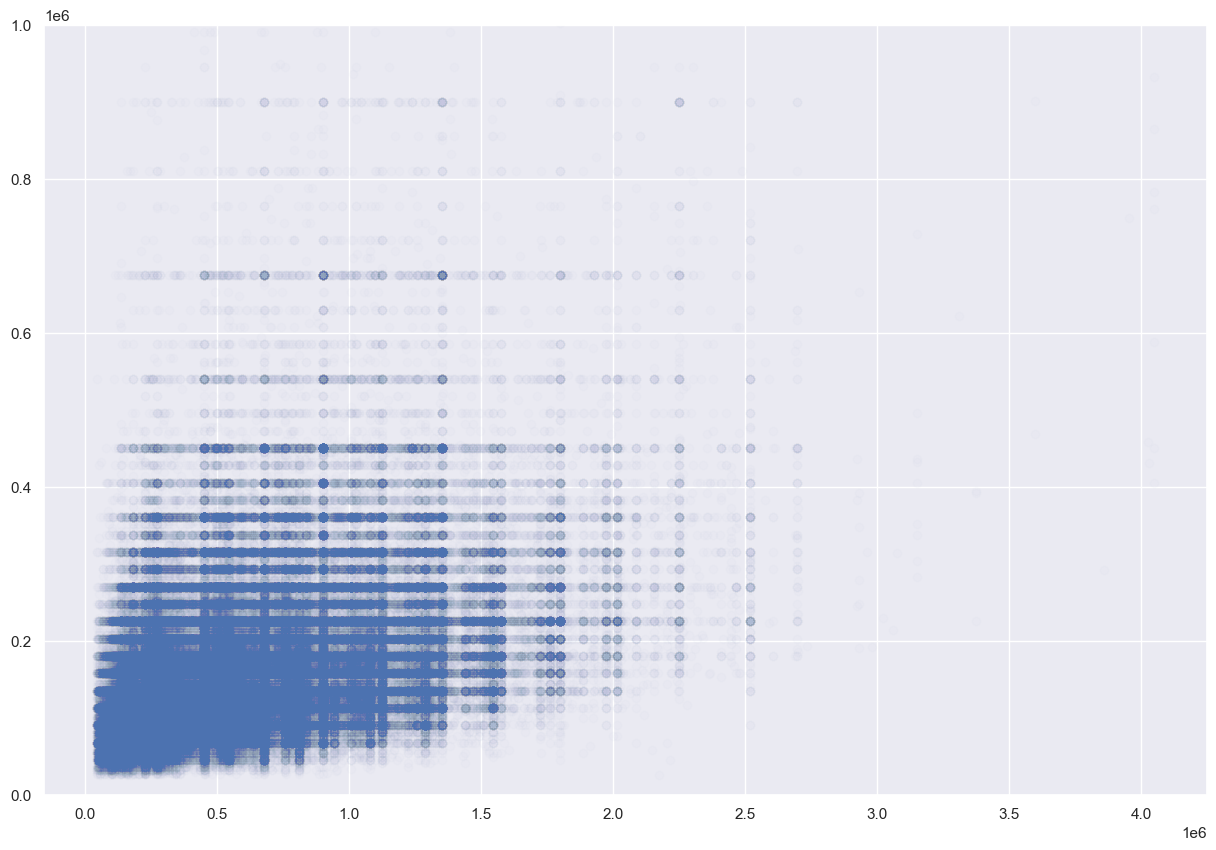

In [32]:
_, ax = plt.subplots()
ax.set_ylim((0, 1e6))
ax.scatter(application_data["AMT_CREDIT"], application_data["AMT_INCOME_TOTAL"],  alpha=0.01)

There we go. By being a bit more careful with our plotting we've revealed that there's a very strong correlation between the amount of credit applied for and the total income of the applicant, which wasn't at all obvious beforehand. 

To end I'd like to show you a custom scatter plotting function and use it to compare 

In [33]:
def split_plot(data, x, y, compcol, aalpha=0.1, balpha=0.1, xlim=None, ylim=None):
    alphamap = {False: aalpha, True: balpha}
    colormap = {False: "tab:blue", True: "red"}
    
    for val in [False, True]:          
        plt.scatter(x, y, data=data[data[compcol] == val], alpha=alphamap[val], s=20, c=colormap[val])
    
    plt.xlabel(x)
    plt.ylabel(y)
    
    if xlim is not None:
        plt.xlim(xlim)
        
    if ylim is not None:
        plt.ylim(ylim)

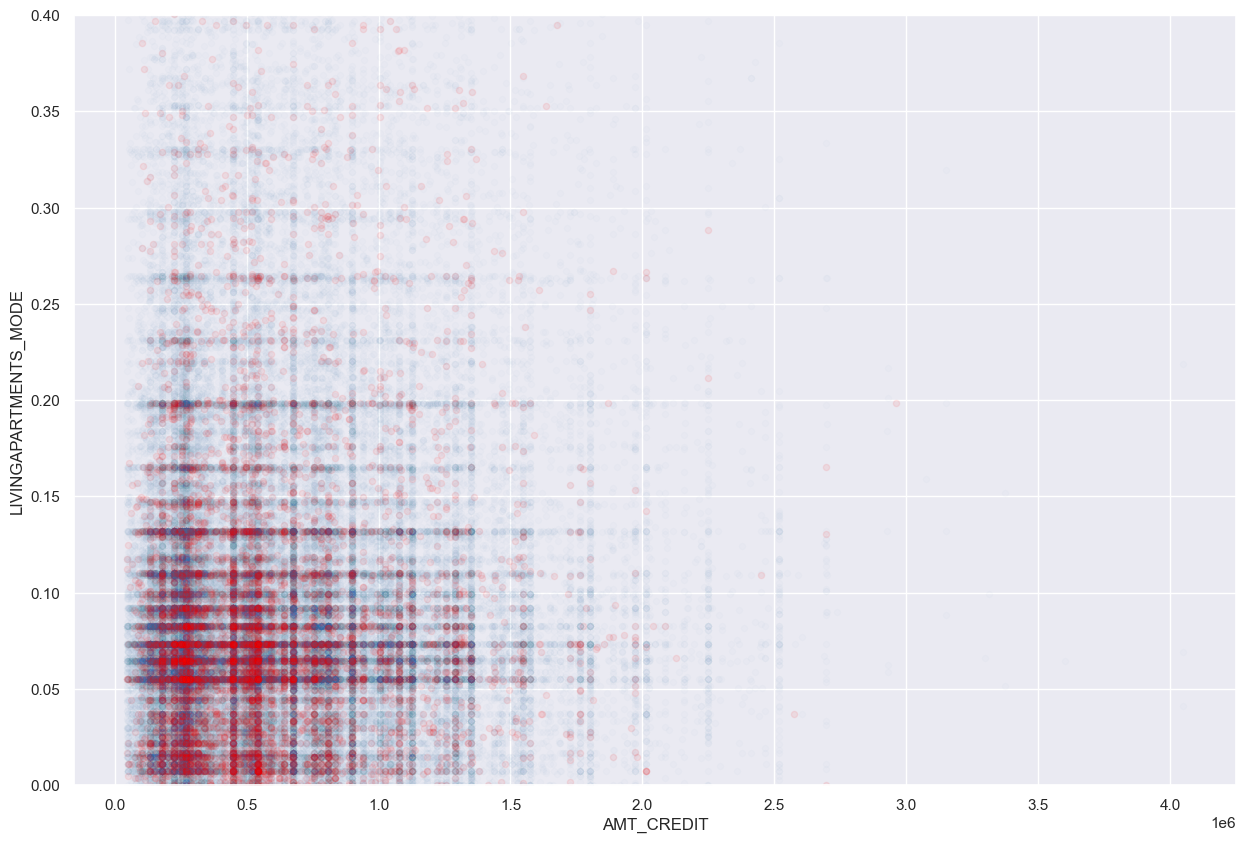

In [34]:
split_plot(application_data,  "AMT_CREDIT", "LIVINGAPARTMENTS_MODE", "TARGET", aalpha=0.01, balpha=0.07, ylim=(0, 0.4))

Here we plot the amount of credit applied for against the mode of the number of living apartments in the building where the applicant lives (see the data explanation (https://www.kaggle.com/mishra5001/credit-card?select=columns_description.csv). Blue dots represent non-fraudlent instances, and red dots represent fraud. 

This allows us to see that fraud seems to occur slightly more often when the number of living apartments is a little higher, though in general fraud seems to be evenly distributed through the data along these axes. 

That's all, now get plotting!

In [4]:
# Bin the values
application_data['LIVINGAPARTMENTS_BIN'] = pd.qcut(application_data['LIVINGAPARTMENTS_MODE'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Use the binned column
split_plot(application_data, "AMT_CREDIT", "LIVINGAPARTMENTS_BIN", "TARGET", aalpha=0.01, balpha=0.07, ylim=(0, 0.4))

NameError: name 'application_data' is not defined